# Comprehensive PPG Analysis

In this tutorial we will learn how to extract biomarkers from a photoplethysmogram (PPG) signal.

Our objectives are to:

- Detect the standard fiducial points on PPG pulse waves
- Calculate pulse wave biomarkers from the fiducial points
- Saving data in different data format

You can use the sample PPG data by downloading it from the following link: [Sample PPG data](https://zenodo.org/record/8369487/files/Sample_PPG_MAT_125Hz.mat?download=1).


## Setup

Import Python packages:
________________________

- Install the _[pyPPG](https://pyppg.readthedocs.io/)_ toolbox for PPG analysis

In [2]:
# !pip install pyPPG==1.0.41

- Import required components from _pyPPG_

In [75]:
from pyPPG import PPG, Fiducials, Biomarkers
from pyPPG.datahandling import load_data, plot_fiducials, save_data
import pyPPG.preproc as PP
import pyPPG.fiducials as FP
import pyPPG.biomarkers as BM
import pyPPG.ppg_sqi as SQI

- Import other packages

In [76]:
import numpy as np
import sys
import json
import pandas as pd

Setup input parameters:
_______________________
_The following input parameters are inputs to the `pyPPG.example` module (see the [documentation](https://pyppg.readthedocs.io/en/latest/pyPPG.html#module-pyPPG.example) for further details)._

In [77]:
data_path = "dataset/data/S001_128.mat" # the path of the file containing the PPG signal to be analysed
start_sig = 0 # the first sample of the signal to be analysed
end_sig = -1 # the last sample of the signal to be analysed (here a value of '-1' indicates the last sample)
savingfolder = 'temp_dir'
savingformat = 'csv'

Load a raw PPG signal:
__________________________

In [97]:
signal = load_data(data_path=data_path, start_sig=start_sig, end_sig=end_sig, use_tk=False)
# signal.v = signal.v [0:20*signal.fs] # 20 second long signal to be analysed
signal.v = signal.v # 20 second long signal to be analysed

[-2.38138363 -2.38135063 -2.38131159 ... -3.93333424 -4.06168546
 -4.2308891 ]


Plot the raw PPG signal:

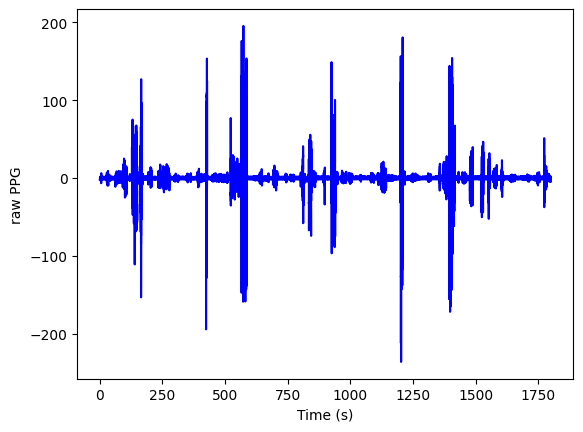

In [98]:
# import plotting package
from matplotlib import pyplot as plt

# setup figure
fig, ax = plt.subplots()

# create time vector
t = np.arange(0, len(signal.v))/signal.fs

# plot raw PPG signal
ax.plot(t, signal.v, color = 'blue')
ax.set(xlabel = 'Time (s)', ylabel = 'raw PPG')

# show plot
plt.show()

## PPG signal processing

Filter the PPG signal and obtain first, second and third derivatives (_vpg_, _apg_, and _jpg_ respectively).

In [99]:
signal.filtering = True # whether or not to filter the PPG signal
signal.fL=0.5000001 # Lower cutoff frequency (Hz)
signal.fH=12 # Upper cutoff frequency (Hz)
signal.order=4 # Filter order
signal.sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"

prep = PP.Preprocess(fL=signal.fL, fH=signal.fH, order=signal.order, sm_wins=signal.sm_wins)
signal.ppg, signal.vpg, signal.apg, signal.jpg = prep.get_signals(s=signal)

Plot the derived signals

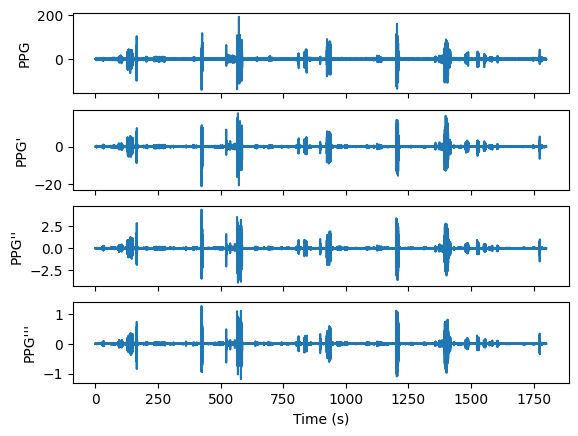

In [100]:
# setup figure
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False)

# create time vector
t = np.arange(0, len(signal.ppg))/signal.fs

# plot filtered PPG signal
ax1.plot(t, signal.ppg)
ax1.set(xlabel = '', ylabel = 'PPG')

# plot first derivative
ax2.plot(t, signal.vpg)
ax2.set(xlabel = '', ylabel = 'PPG\'')

# plot second derivative
ax3.plot(t, signal.apg)
ax3.set(xlabel = '', ylabel = 'PPG\'\'')

# plot third derivative
ax4.plot(t, signal.jpg)
ax4.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'\'')

# show plot
plt.show()

Store the derived signals in a class

In [101]:
# Initialise the correction for fiducial points
corr_on = ['on', 'dn', 'dp', 'v', 'w', 'f']
correction=pd.DataFrame()
correction.loc[0, corr_on] = True
signal.correction=correction

# Create a PPG class
s = PPG(signal)

C:\Users\robbe\AppData\Local\Temp\ipykernel_2004\2141082969.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correction.loc[0, corr_on] = True


Identify fiducial points:
__________________________

Initialise the fiducials package

In [102]:
fpex = FP.FpCollection(s)

Extract fiducial points

In [103]:
fiducials = fpex.get_fiducials(s)

Display the results

In [104]:
print("Fiducial points:\n",fiducials + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)

Fiducial points:
                     on      sp      dn      dp     off       u       v  \
Index of pulse                                                           
0                    0      80     105    <NA>     136      63      87   
1                  136     165     188    <NA>     218     146     179   
2                  218     246     270    <NA>     300     228     262   
3                  300     329     351    <NA>     372     310     344   
4                  372     395     423    <NA>     459     381     414   
...                ...     ...     ...     ...     ...     ...     ...   
2155            228771  228816  228830  228833  228877  228799  228824   
2156            228877  228927  228963  229004  229052  228988  228990   
2157            229052  229089  229100  229102  229133  229080  229093   
2158            229133  229191  229217    <NA>  229237  229161  229199   
2159            229237  229311  229341  229362  229412  229348  229350   

                   

Plot fiducial points
__________________________

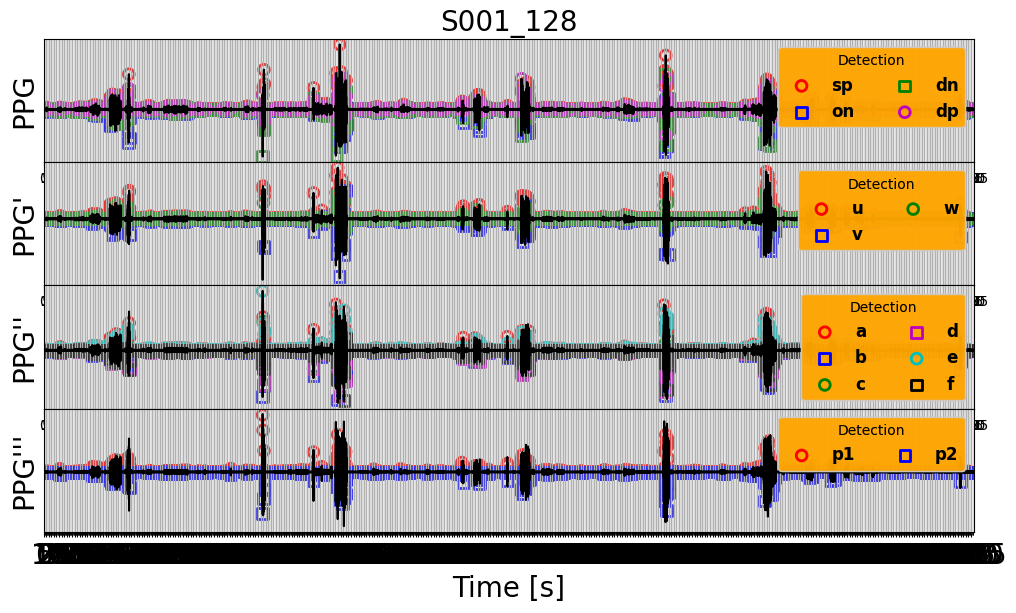

Figure has been saved in the "temp_dir\PPG_Figures\".


In [105]:
# Create a fiducials class
fp = Fiducials(fiducials)

# Plot fiducial points
plot_fiducials(s, fp, savingfolder, legend_fontsize=12)

Calculate PPG SQI:
_________________________

In [106]:
# Get PPG SQI
ppgSQI = round(np.mean(SQI.get_ppgSQI(s.ppg, s.fs, fp.sp)) * 100, 2)
print('Mean PPG SQI: ', ppgSQI, '%')

Mean PPG SQI:  62.03 %


Calculate PPG biomarkers:
_________________________

Initialise the biomarkers package

In [107]:
bmex = BM.BmCollection(s, fp)

Extract biomarkers

In [108]:
bm_defs, bm_vals, bm_stats = bmex.get_biomarkers()
tmp_keys=bm_stats.keys()
print('Statistics of the biomarkers:')
for i in tmp_keys: print(i,'\n',bm_stats[i])

# Create a biomarkers class
bm = Biomarkers(bm_defs, bm_vals, bm_stats)

c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i] = lst
c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i

no more peaks


c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i] = lst
c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i

no more peaks


c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i] = lst
c:\Users\robbe\OneDrive - UGent\UGent\Ma2\Methods & Applications of AI in Biomedicine [I.C.]\Applied AI in Biomedicine (Corino Valentina)\AI_PPG\pyPPG\ppg_bm\bm_extraction.py:1288: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biomarkers.loc[i

no more peaks
no more peaks
Statistics of the biomarkers:
ppg_sig 
                      Tpi        Tpp       Tsys  Tdia       Tsp  Tdp  deltaT  \
Statistics                                                                    
mean            0.853307   0.854111   0.450713   NaN  0.257658  NaN     NaN   
median          0.734375   0.742188   0.429688   NaN  0.242188  NaN     NaN   
std             0.439287   0.440290   0.120043   NaN  0.086961  NaN     NaN   
percentile_25   0.648438   0.632812   0.390625   NaN  0.195312  NaN     NaN   
percentile_75   0.882812   0.914062   0.500000   NaN  0.289062  NaN     NaN   
iqr             0.234375   0.281250   0.109375   NaN  0.093750  NaN     NaN   
skew            5.935898   5.521234   2.054219   NaN  1.859151  NaN     NaN   
kurtosis       53.407353  47.279847  10.105765   NaN  7.480193  NaN     NaN   
mad             0.247035   0.251925   0.083213   NaN  0.061954  NaN     NaN   

                  Tsw10     Tsw25     Tsw33  ...      Tpw66   

Save PPG data:
______________

In [109]:
# Save PPG struct, fiducial points, biomarkers
fp_new = Fiducials(fp.get_fp() + s.start_sig) # here the starting sample is added so that the results are relative to the start of the original signal (rather than the start of the analysed segment)
save_data(s, fp_new, bm, savingformat, savingfolder)

AttributeError: 'Fiducials' object has no attribute 'replace'

In [110]:
print(list(range(6 - 1)))

[0, 1, 2, 3, 4]


In [111]:
print(dir(fp.on))

['T', '_AXIS_LEN', '_AXIS_ORDERS', '_AXIS_TO_AXIS_NUMBER', '_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__array_ufunc__', '__bool__', '__class__', '__column_consortium_standard__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__finalize__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pandas_priority__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfl

In [112]:
print(fp.on.shape)

(2160,)


In [113]:
print(bm_vals.keys())

dict_keys(['ppg_sig', 'sig_ratios', 'ppg_derivs', 'derivs_ratios'])


In [114]:
bm_vals['derivs_ratios'].head()

name,TimeStamp,Tu/Tpi,Tv/Tpi,Tw/Tpi,Ta/Tpi,Tb/Tpi,Tc/Tpi,Td/Tpi,Te/Tpi,Tf/Tpi,...,(Ac-Ab)/Aa,(Ad-Ab)/Aa,AGI,AGImod,AGIinf,AI,RIp1,RIp2,SC,IPAD
Index of pulse,,,,,,,,,,,,,,,,,,,,,
3,300,0.151515,0.666667,0.954545,0.060606,0.212121,0.333333,0.424242,0.878788,0.969697,...,0.342199,0.288525,-0.121815,-0.029952,-0.692634,0.344115,NaN,NaN,-0.006846,0.303312
4,372,0.093750,0.437500,0.583333,0.020833,0.135417,0.239583,0.250000,0.500000,0.583333,...,0.523250,0.524255,-0.351490,-0.318293,-0.762410,0.191121,NaN,NaN,-0.003796,0.093583
6,548,0.164179,0.656716,0.955224,0.059701,0.208955,0.343284,0.417910,0.880597,0.970149,...,0.347402,0.278797,-0.152601,-0.061134,-0.656531,0.473377,NaN,NaN,-0.005923,0.164674
7,620,0.095238,0.438095,0.495238,0.028571,0.133333,0.219048,0.247619,0.457143,0.523810,...,0.529516,0.536648,-0.409115,-0.310333,-0.854614,0.144385,0.714960,0.714960,-0.005650,0.221898
8,713,0.323944,0.647887,0.746479,0.042254,0.169014,0.253521,0.394366,0.676056,0.816901,...,0.611579,-0.538174,-0.005261,0.159443,-0.397553,0.501798,6.554463,6.554463,-0.040426,0.140049


In [115]:
bm_vals['derivs_ratios'].shape[0]

1263

In [116]:
fp.on.shape[0]

2160